In [61]:
%load_ext autoreload
%autoreload 2


In [62]:
from domino.slices import collect_settings
from domino.slices.celeba import CelebASliceBuilder
from domino.evaluate import run_sdm, score_sdms, run_sdms
from domino.train import train_settings
import numpy as np
import terra
from domino.emb.clip import embed_phrases

In [63]:
score_df = score_sdms.out().load()

In [64]:
score_df.iloc[score_df.reset_index().groupby(["target_name", "slice_name", "slice_idx"])['precision_at_10'].idxmax().astype(int)]

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_name,run_sdm_run_id,slice_name
20,0,0,0.945949,0.9,0.96,0.69,0.176471,0.289916,0.449580,0.210084,0.413223,goatee,16973,goatee=0_mustache=1
15,0,1,0.999246,1.0,1.00,0.99,0.000000,0.000000,0.758755,1.000000,0.969811,goatee,16972,goatee=1_mustache=0
121,1,0,0.867163,1.0,0.92,0.75,0.031605,0.060778,0.124797,0.100486,0.681319,smiling,16983,smiling=0_wearing_lipstick=1
135,0,1,0.944160,1.0,1.00,1.00,0.041288,0.082576,0.165153,0.316268,0.401047,smiling,16984,smiling=1_wearing_lipstick=0
61,1,0,0.816711,0.9,0.76,0.54,0.132812,0.210938,0.285156,0.996094,0.068164,wearing_hat,16977,wearing_hat=0_goatee=1
45,0,1,0.933487,0.6,0.68,0.66,0.136564,0.290749,0.515419,0.960352,0.071758,wearing_hat,16975,wearing_hat=1_goatee=0
91,1,0,0.785046,0.8,0.76,0.62,0.088095,0.147619,0.223810,0.500000,0.084712,wearing_necklace,16980,wearing_necklace=0_bangs=1
98,3,1,0.974338,1.0,0.80,0.68,0.085714,0.161905,0.302381,0.352381,0.471338,wearing_necklace,16980,wearing_necklace=1_bangs=0


In [89]:
inp = run_sdm.inp(run_id=16983, load=True)
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)
slice_idx = 0
inp["slice_names"][slice_idx]

'smiling=0_wearing_lipstick=1'

In [90]:
from domino.metrics import compute_model_metrics
compute_model_metrics(data_dp, num_iter=10)

ValueError: DataPanel passed to `compute_model_metrics` at argument `dp` is missing required columns `['output']`.

In [91]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=25, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

 82%|████████▏ | 82/100 [00:03<00:00, 24.15it/s]


In [92]:
from domino.metrics import compute_sdm_metrics

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(
    by="auroc", ascending=False
)


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
2,2,0,0.967964,1.0,1.00,1.00,0.040519,0.081037,0.161264,0.514587,0.913669
1,1,0,0.893310,0.4,0.36,0.48,0.019449,0.038898,0.080227,0.485413,0.243101
0,0,0,0.124913,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0,0.098120,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0,0.031820,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [102]:
words_dp = embed_phrases.out().load()
words_dp = words_dp.lz[:10_000]
sdm.explain(
    words_dp=words_dp,
    data_dp=dp
)

KeyError: "DataPanel does not have columns {'frequency'}"

In [99]:
#attribute = "mustache"

words_dp = embed_phrases.out().load()
words_dp = words_dp.lz[:10_000]

pred_slice_idx = 2
words_dp = words_dp.view()
slice_proto = (
    np.dot(dp["pred_slices"].T, dp["emb"])
    / dp["pred_slices"].sum(axis=0, keepdims=True).T
)
#pred_slice = dp["pred_slices"][:, pred_slice_idx]
#slice_proto = dp.lz[pred_slice.argsort()[-40:]]["emb"].mean(axis=0)
#slice_proto = dp["emb"][dp[attribute] == 1].mean(axis=0)
#slice_proto = dp.lz[dp["probs"].argsort()[-25:]]["emb"].mean(axis=0)


ref_proto = dp["emb"][dp["target"] == 0].data.mean(axis=0)

words_dp["pred_slices"] = np.dot(
    words_dp["emb"].data, (slice_proto - ref_proto).T
)
expl_dp = words_dp[["word", "pred_slices"]]
expl_dp.lz[(-expl_dp["pred_slices"]).argsort()[0:10]]

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

,image (ImageColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn)
0,,0,1
1,,0,1
2,,0,1
3,,0,1
4,,0,1
5,,0,1
6,,0,1
7,,0,1
8,,0,1
9,,0,1

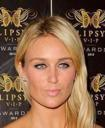
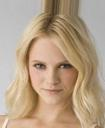
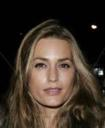
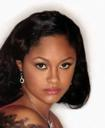
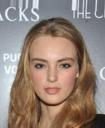
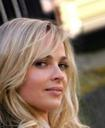
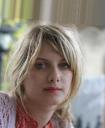
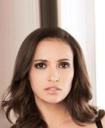
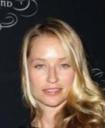
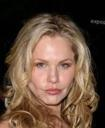

In [97]:

dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-10:]][["image", "target", "correlate"]]

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plot_df = pd.DataFrame(
    {"probs": dp["probs"], "slice": dp["slices"][:, slice_idx], "target": dp["target"]}
)
sns.histplot(
    data=plot_df[plot_df["target"] == 0],
    x="probs",
    hue="slice",
    stat="count",
    common_norm=not False,
    binwidth=0.1,
)
plt.yscale("log")


ValueError: Data must be 1-dimensional

In [6]:
from domino.train import score_settings, train_settings, score_model, train_model

In [82]:
attribute = "mustache"

words_dp = embed_phrases.out().load()
words_dp = words_dp.lz[:10_000]

pred_slice_idx = 0
words_dp = words_dp.view()
slice_proto = (
    np.dot(dp["pred_slices"].T, dp["emb"])
    / dp["pred_slices"].sum(axis=0, keepdims=True).T
)
slice_proto = dp["emb"][dp[attribute] == 1].mean(axis=0)
#slice_proto = dp.lz[dp["probs"].argsort()[-25:]]["emb"].mean(axis=0)


ref_proto = dp["emb"][dp[attribute] == 0].data.mean(axis=0)

words_dp["pred_slices"] = np.dot(
    words_dp["emb"].data, (slice_proto - ref_proto).T
)
expl_dp = words_dp[["word", "pred_slices"]]
expl_dp.lz[(-expl_dp["pred_slices"]).argsort()[0:10]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,a photo of a man with mustaches.,4.753906
1,a photo of a man with mustache.,4.718750
2,a photo of a man with a mustache.,4.652344
3,a photo of a guy with mustache.,4.445312
4,a photo of a guy with mustaches.,4.421875
5,a photo of a man in blackness.,4.371094
6,a photo of a man with swagger.,4.277344
7,a photo of a guy with facial hair.,4.207031
8,a photo of a man of quality.,4.183594
9,a photo of a man to relate to.,4.125000


In [5]:
score_settings.out().load()["score_model_run_id"]

,(PandasSeriesColumn)
0,15006
1,15007
2,15008
3,15005
4,15009
5,15010
6,15011
7,15012
8,15014
9,15013


In [8]:
score_dp = score_model.out(15006).load()

In [18]:
from sklearn.metrics import roc_auc_score
mask = score_dp["target"] != score_dp["correlate"]
roc_auc_score(score_dp.lz[mask]["target"], score_dp.lz[mask]["probs"][:, 1])

0.26252927075972343

In [13]:
score_dp["probs"] = score_dp["output"].probabilities()

In [10]:
from domino.train import score_settings, synthetic_score_settings, score_model

In [5]:
type(synthetic_score_settings.out().load())

meerkat.datapanel.DataPanel

In [19]:
score_settings.out()[0].load()

,train_model_run_id (PandasSeriesColumn),setting_id (NumpyArrayColumn),corr (NumpyArrayColumn),correlate (PandasSeriesColumn),dataset (PandasSeriesColumn),n (NumpyArrayColumn),slice_category (PandasSeriesColumn),target (PandasSeriesColumn),index (PandasSeriesColumn),parent_run_id (PandasSeriesColumn),build_setting_run_id (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),config/corr (PandasSeriesColumn),config/correlate (PandasSeriesColumn),config/dataset (PandasSeriesColumn),config/index (PandasSeriesColumn),config/n (PandasSeriesColumn),config/setting_id (PandasSeriesColumn),config/slice_category (PandasSeriesColumn),config/target (PandasSeriesColumn),logdir (PandasSeriesColumn),score_settings_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn),synthetic_preds (PandasSeriesColumn)
0,14936,163,0.6,blond_hair,celeba,30000,correlation,wearing_necklace,0,14928,14930,1112.037066,False,NaN,NaN,1,8ef98aebaa294f1f8875ae337af348ea,2021-09-22_12-08-35,1632312515,1112.037066,198,run-script-nf5ts,10.92.1.25,1112.037066,0,1,36c4b_00000,0.6,blond_hair,celeba,163,30000,163,correlation,wearing_necklace,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00000_0_config={'corr': 0.6000000000000001, 'correlate': 'blond_hair', 'dataset': 'celeba', 'n': 30000, 'slice__2021-09-22_11-49-59",15044,15045,False
1,14933,139,0.8,eyeglasses,celeba,30000,correlation,wearing_hat,1,14928,14931,1116.230135,False,NaN,NaN,1,20a0c9441e584990983fc829547b6915,2021-09-22_12-08-39,1632312519,1116.230135,196,run-script-nf5ts,10.92.1.25,1116.230135,0,1,36c4b_00001,0.8,eyeglasses,celeba,139,30000,139,correlation,wearing_hat,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00001_1_config={'corr': 0.8, 'correlate': 'eyeglasses', 'dataset': 'celeba', 'n': 30000, 'slice_category': 'cor_2021-09-22_11-49-59",15044,15046,False


In [24]:
score_model.out(15045)[0].load()["split"].unique()

array(['train', 'valid'], dtype=object)

In [56]:
from domino.data.celeba import get_celeba_dp

In [96]:
sb = CelebASliceBuilder()
out = sb.build_rare_setting(
    data_dp=get_celeba_dp.out().load(),
    target_attrs=["wearing_earrings", "male", "blond_hair"],
    slice_attrs=["blond_hair"],
    slice_frac=0.01,
    target_frac=0.5,
    n=20_000
)

In [99]:
out["wearing_earrings"].mean()

0.1394

In [84]:
np.any(out == 1, axis=0).mean()

0.7881282730911802

In [73]:
 data_dp=get_celeba_dp.out().load()

In [85]:
target_attrs=["wearing_earrings", "male", "blond_hair"]

targets = np.array(
            [data_dp[attr] for attr in target_attrs]
)


In [100]:
train_settings.out()

NameError: name 'train_settings' is not defined

In [97]:
from domino.emb.clip import get_wiki_words
dp = get_wiki_words(top_k=10_000, eng_only=True).load()
(dp["word"] == "earrings").any()

task: get_wiki_words, run_id=16792


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


False

In [98]:
dp

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn)
0,the,151983633.0,0
1,of,71874676.0,1
2,and,62210193.0,2
3,in,62004799.0,3
4,to,43364193.0,4
...,...,...,...
9995,het,5533.0,9995
9996,cleric,5531.0,9996
9997,unfavorable,5528.0,9997
9998,disperse,5528.0,9998


In [104]:
"blond" in dp["word"]

False

In [5]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
from nltk.corpus import wordnet as wn
nl

In [71]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("A portrait of a person", max_length=7, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'A portrait of a person who died'},
 {'generated_text': "A portrait of a person's head"},
 {'generated_text': 'A portrait of a person holding down'},
 {'generated_text': 'A portrait of a person who will'},
 {'generated_text': 'A portrait of a person wearing long'}]

In [17]:
hypernyms = []
for hypernym in synset.closure(lambda s: s.hypernyms()):
    hypernyms.append(
        {
            "synset": synset.name(),
            "hypernym": hypernym.name(),
        }
    )
hypernyms

[{'synset': 'smile.n.01', 'hypernym': 'facial_expression.n.01'},
 {'synset': 'smile.n.01', 'hypernym': 'gesture.n.02'},
 {'synset': 'smile.n.01', 'hypernym': 'visual_communication.n.01'},
 {'synset': 'smile.n.01', 'hypernym': 'communication.n.02'},
 {'synset': 'smile.n.01', 'hypernym': 'abstraction.n.06'},
 {'synset': 'smile.n.01', 'hypernym': 'entity.n.01'}]

In [27]:
from transformers import pipeline, set_seed

In [28]:
unmasker = pipeline('fill-mask', model='xlm-roberta-base')

In [26]:
unmasker = pipeline("", max_length=30, num_return_sequences=5)

PipelineException: No mask_token (<mask>) found on the input

In [41]:
unmasker(f"A photo of a person .")

[{'sequence': 'A photo of a person, smiling.',
  'score': 0.40710172057151794,
  'token': 4,
  'token_str': ','},
 {'sequence': 'A photo of a person while smiling.',
  'score': 0.08363543450832367,
  'token': 12960,
  'token_str': 'while'},
 {'sequence': 'A photo of a person still smiling.',
  'score': 0.0663875937461853,
  'token': 7464,
  'token_str': 'still'},
 {'sequence': 'A photo of a person not smiling.',
  'score': 0.025921307504177094,
  'token': 959,
  'token_str': 'not'},
 {'sequence': 'A photo of a person is smiling.',
  'score': 0.0218026302754879,
  'token': 83,
  'token_str': 'is'}]

In [3]:
templates = [
    "a photo of a person {}",
    "a photo of a person {} [MASK]",
    "a photo of a person {} [MASK] [MASK]",
    "a photo of a person [MASK] {}",
    "a photo of a person [MASK] {} [MASK]",
    "a photo of a person [MASK] {} [MASK][MASK]",
    "a photo of a person [MASK] [MASK] {}",
    "a photo of a person [MASK] [MASK] {} [MASK]",
    "a photo of a person [MASK] [MASK] {} [MASK] [MASK]",
]

In [68]:
import torch
from transformers import BertTokenizer, BertModel,BertForMaskedLM
 
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

word = "smiling"
input_txt = [template.format(word) for template in templates]

inputs = tokenizer(input_txt, return_tensors='pt', padding=True).to(0)


model = BertForMaskedLM.from_pretrained('bert-large-cased').to(0)

outputs = model(**inputs)
predictions = outputs
# sorted_preds, sorted_idx = predictions[0].sort(dim=-1, descending=True)
# for k in range(10):
#     predicted_index = [sorted_idx[i, k if inputs["input_ids"][1, i] == 103 else 0].item() for i in range(0, inputs["input_ids"].shape[-1])]
#     predicted_token = [tokenizer.convert_ids_to_tokens([predicted_index[x]])[0] for x in range(1,inputs["input_ids"].shape[-1])]
#     print(predicted_token)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
sorted_preds, sorted_ids = predictions.logits.sort(dim=-1, descending=True)

In [62]:
sorted_preds.shape

torch.Size([9, 12, 28996])

In [66]:
input_ids = inputs["input_ids"]
for rank in range(10):
    curr_ids = sorted_ids[:, :, rank]
    curr_ids[input_ids != 103] = input_ids[input_ids != 103]
    for sent_idx in range(sorted_ids.shape[0]):

        candidate_df.append(
            {
                "text": tokenizer.decode(
                    sorted_ids[sent_idx, :, rank], skip_special_tokens=True
                ),
                "prob": sorted_preds[sent_idx, :, rank].mean().cpu().detach().numpy(),
            }
        )
candidate_df = pd.DataFrame(candidate_df)

In [67]:
candidate_df.sort_values("prob")

,text,prob
89,a photo of a person - ; smiling widely and,7.0040717
86,a photo of a person standing smiling now and,7.0434494
88,a photo of a person with while smiling -,7.0881395
87,a photo of a person crying - smiling,7.1516395
80,"a photo of a person'- smiling eyes """,7.2351427
...,...,...
7,"a photo of a person, and smiling.",14.271441
4,"a photo of a person, smiling ;",14.699389
2,a photo of a person smiling broadly ;,14.843798
0,a photo of a person smiling,15.80104


In [56]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np 

gpt_model = GPT2LMHeadModel.from_pretrained('gpt2').to(0)
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

scores = []
for text in sents:
    tokens_tensor = gpt_tokenizer.encode( text, add_special_tokens=False, return_tensors="pt").to(0) 
    loss=gpt_model(tokens_tensor, labels=tokens_tensor)[0]
    scores.append( 
        {"prob": np.exp(loss.cpu().detach().numpy()), "text": text}       
    )
dp = pd.DataFrame(scores)

In [57]:
dp.sort_values("prob")

,prob,text
6,86.902687,a photo of a person sitting and smiling
10,87.852638,a photo of a person smiling.
55,88.414558,a photo of a person smiling and
15,88.646149,"a photo of a person standing, smiling"
24,92.471436,a photo of a person smiling or smiling
...,...,...
41,735.416260,"a photo of a person "" smiling brightly..."
70,774.525269,a photo of a person - / smiling :
69,852.903381,a photo of a person and ; smiling
59,915.673279,a photo of a person in smiling happily |


In [3]:
from domino.emb.clip import get_wiki_words
#dp = get_wiki_words(top_k=25_000, eng_only=True).load()
dp = get_wiki_words.out().load()

In [4]:
from domino.emb.clip import generate_phrases
from domino.data.celeba import PHRASE_TEMPLATES

In [5]:
phrase_dp = generate_phrases(dp[100:300], templates=PHRASE_TEMPLATES)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 14.76 GiB total capacity; 13.66 GiB already allocated; 5.75 MiB free; 13.72 GiB reserved in total by PyTorch)

In [96]:
phrase_dp.to_pandas().sort_values("prob").iloc[-15:]

,prob,output_phrase,index
49,19.365196,a photo of a person at work.,49
10,19.511856,a photo of a person until.,10
45,19.523741,a photo of a person work,45
64,19.532944,a photo of a person following.,64
85,19.544060,a photo of a person or people.,85
81,19.562103,a photo of a person people,81
63,19.627256,a photo of a person following,63
55,19.633055,a photo of a person life.,55
65,19.857872,a photo of a person following her ;,65
28,20.410408,a photo of a person since.,28


In [60]:
"hello world".replace("world", "akjf")

'hello akjf'